Kelompok 9:
- Adham Erlangga Siwi
- Rizaldi Yusuf 

# Import Libraries

In [1]:
#untuk mengolah data
import pandas as pd
import numpy as np
import re
import string
import ast
from imblearn.over_sampling import SMOTE

#untuk pengolahan (membersihkan) teks
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

#untuk visualisasi
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import islice
import difflib

#untuk membangun model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import model_selection, svm
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score,recall_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from joblib import dump

In [2]:
#load dataset
df = pd.read_csv('cnn_dataset.csv')
df.head()

,Link,Title,Date,Text,Category
0,https://www.cnnindonesia.com/nasional/20211203...,Bamsoet Bertemu Sri Mulyani: Agar Tak Salah Paham,"Jumat, 03 Dec 2021 21:18 WIB",Pimpinan MPR menggelar forum resmi dengan Ment...,Nasional
1,https://www.cnnindonesia.com/internasional/202...,UEA Rekor Beli 80 Jet Tempur Prancis Setara Rp...,"Jumat, 03 Dec 2021 21:04 WIB",Uni Emirat Arab (UEA) menandatangani kontrak r...,Internasional
2,https://www.cnnindonesia.com/hiburan/202112031...,BTS Usai Konser Permission to Dance: See You i...,"Jumat, 03 Dec 2021 21:00 WIB",BTS telah selesai menggelar konser bertajuk BT...,Hiburan
3,https://www.cnnindonesia.com/teknologi/2021120...,"FOTO: 50 Tahun 'Tersembunyi', Iran Pamerkan Mo...","Jumat, 03 Dec 2021 21:00 WIB",NaN,Teknologi
4,https://www.cnnindonesia.com/nasional/20211203...,Ketua Panja RUU TPKS: Semoga Ada Titik Cerah,"Jumat, 03 Dec 2021 20:56 WIB",Ketua Panitia Kerja Rancangan Undang-undang Ti...,Nasional


In [3]:
#menampilkan informasi umum dari dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      4157 non-null   object
 1   Title     4157 non-null   object
 2   Date      4157 non-null   object
 3   Text      3838 non-null   object
 4   Category  4157 non-null   object
dtypes: object(5)
memory usage: 162.5+ KB


In [4]:
#check data yang Nan
df.isna().sum()

Link          0
Title         0
Date          0
Text        319
Category      0
dtype: int64

In [5]:
#drop baris yang kosong pada kolom text
df.dropna(subset = ['Text'],inplace = True)
#check data kembali
df.isna().sum()

Link        0
Title       0
Date        0
Text        0
Category    0
dtype: int64

kini dataset sudah bersih dari baris yang kosong

In [6]:
df['Category'].value_counts()

Nasional         1303
Ekonomi           633
Olahraga          617
Internasional     343
Teknologi         333
Gaya Hidup        306
Hiburan           303
Name: Category, dtype: int64

# Cleaning

membersihkan data dari url, hex characters, baris baru (\n), mention, hashtag, single char (contoh: a), angka, spasi dari awal teks, dan multiplechar (contoh: enggggggga)

In [7]:
def cleaning(text):
  #remove url
  text = re.sub(r"http\S+", "", text)
  #remove hex characters
  text = re.sub(r'(\\x(.){2})', '', text)
  #remove newlines
  text = re.sub(r'\s+|\\n', ' ', text)
  #remove hashtags
  text = re.sub(r'\B#\w*[a-zA-Z]+\w*','', text)
  #remove single char
  text = re.sub(r'\b[a-zA-Z]\b','', text)
  #remove number
  text = re.sub(r'\d+','', text)
  #remove punctuation / tanda baca
  text = re.sub(r'[^\w\s]+', ' ', text)
  #remove spasi dari awal teks
  text = re.sub(r"/^\\s+/m", '', text)
  #remove character yang memilliki kurang dari 3 huruf
  text = re.sub(r'\b\w{1,3}\b', '', text)
  return text

df['Cleaning'] = df['Text'].apply(cleaning)

In [8]:
#contoh data yang sudah dibersihkan
for i in df.loc[2][['Text','Cleaning']]:
    print(i,'\n')

BTS telah selesai menggelar konser bertajuk BTS PERMISSION TO DANCE ON STAGE - LA. Setelah Los Angeles, BTS menyatakan bakal menyambut fan atau ARMY di Seoul pada 2022.,Hal tersebut diumumkan melalui akun resmi media sosial BTS pada Jumat (3/12). ARMY meyakini jadwal itu merupakan rencana konser BTS selanjutnya dalam waktu dekat.,"Sampai bertemu di Seoul, Maret 2022," tulis cuitan tersebut.,Pengumuman itu disertai dengan foto para member BTS dengan latar tema seperti konser Permission To Dance On Stage - LA.,Sebelumnya, konser PERMISSION TO DANCE ON STAGE - LA resmi berakhir pada Kamis (2/12). Band Inggris Coldplay ikut meramaikan hari terakhir konser BTS itu. BTS dan Coldplay membawakan single kolaborasi mereka, My Universe.,Selain Coldplay, rapper Megan Thee Stallion juga turut meramaikan konser BTS itu. Megan tampil di hari kedua konser yang berlangsung pada 28 November.,Megan Thee Stallion tampil bersama BTS membawakan single Butter versi remix. Ini merupakan kali pertama mereka me

# Casefolding

Mengubah huruf kapital menjadi huruf kecil, agar kata seperti "Tes" dan "tes" menjadi "tes" dan "tes" (seragam)

In [9]:
df['Casefolding'] = df['Cleaning'].str.lower()

In [10]:
for i in df.loc[2][['Cleaning','Casefolding']]:
    print(i,'\n')

 telah selesai menggelar konser bertajuk  PERMISSION  DANCE  STAGE     Setelah  Angeles   menyatakan bakal menyambut  atau ARMY  Seoul pada   tersebut diumumkan melalui akun resmi media sosial  pada Jumat   ARMY meyakini jadwal  merupakan rencana konser  selanjutnya dalam waktu dekat Sampai bertemu  Seoul  Maret   tulis cuitan tersebut Pengumuman  disertai dengan foto para member  dengan latar tema seperti konser Permission  Dance  Stage    Sebelumnya  konser PERMISSION  DANCE  STAGE    resmi berakhir pada Kamis   Band Inggris Coldplay ikut meramaikan hari terakhir konser      Coldplay membawakan single kolaborasi mereka   Universe Selain Coldplay  rapper Megan Thee Stallion juga turut meramaikan konser    Megan tampil  hari kedua konser yang berlangsung pada  November Megan Thee Stallion tampil bersama  membawakan single Butter versi remix   merupakan kali pertama mereka membawakan Butter versi remix secara langsung setelah single kolaborasi  dirilis Agustus lalu  juga bertemu kembali

# Tokenizing

memisahkan kalimat menjadi potongan kata dengan menggunakan library word_tokenize dari nltk

In [11]:
df['Tokenized'] = df['Casefolding'].apply(word_tokenize)

In [12]:
for i in df.loc[2][['Casefolding','Tokenized']]:
    print(i,'\n')

 telah selesai menggelar konser bertajuk  permission  dance  stage     setelah  angeles   menyatakan bakal menyambut  atau army  seoul pada   tersebut diumumkan melalui akun resmi media sosial  pada jumat   army meyakini jadwal  merupakan rencana konser  selanjutnya dalam waktu dekat sampai bertemu  seoul  maret   tulis cuitan tersebut pengumuman  disertai dengan foto para member  dengan latar tema seperti konser permission  dance  stage    sebelumnya  konser permission  dance  stage    resmi berakhir pada kamis   band inggris coldplay ikut meramaikan hari terakhir konser      coldplay membawakan single kolaborasi mereka   universe selain coldplay  rapper megan thee stallion juga turut meramaikan konser    megan tampil  hari kedua konser yang berlangsung pada  november megan thee stallion tampil bersama  membawakan single butter versi remix   merupakan kali pertama mereka membawakan butter versi remix secara langsung setelah single kolaborasi  dirilis agustus lalu  juga bertemu kembali

# Normalisasi

mengubah kata seperti kata gaul dan singkatan menjadi kata normalnya
contoh: 7an -> tujuan

sumber file: https://github.com/louisowen6/NLP_bahasa_resources

In [13]:
#membaca data dan mengubahnya menjadi dictionary
file = open("combined_slang_words.txt", "r")

contents = file.read()
kamus = ast.literal_eval(contents)

file.close()
print(type(kamus))
kamus

<class 'dict'>


{'@': 'di',
 'abis': 'habis',
 'ad': 'ada',
 'adlh': 'adalah',
 'afaik': 'as far as i know',
 'ahaha': 'haha',
 'aj': 'saja',
 'ajep-ajep': 'dunia gemerlap',
 'ak': 'saya',
 'akika': 'aku',
 'akkoh': 'aku',
 'akuwh': 'aku',
 'alay': 'norak',
 'alow': 'halo',
 'ambilin': 'ambilkan',
 'ancur': 'hancur',
 'anjrit': 'anjing',
 'anter': 'antar',
 'ap2': 'apa-apa',
 'apasih': 'apa sih',
 'apes': 'sial',
 'aps': 'apa',
 'aq': 'saya',
 'aquwh': 'aku',
 'asbun': 'asal bunyi',
 'aseekk': 'asyik',
 'asekk': 'asyik',
 'asem': 'asam',
 'aspal': 'asli tetapi palsu',
 'astul': 'asal tulis',
 'ato': 'atau',
 'au ah': 'tidak mau tahu',
 'awak': 'saya',
 'ay': 'sayang',
 'ayank': 'sayang',
 'b4': 'sebelum',
 'bakalan': 'akan',
 'bandes': 'bantuan desa',
 'bangedh': 'banget',
 'banpol': 'bantuan polisi',
 'banpur': 'bantuan tempur',
 'basbang': 'basi',
 'bcanda': 'bercanda',
 'bdg': 'bandung',
 'begajulan': 'nakal',
 'beliin': 'belikan',
 'bencong': 'banci',
 'bentar': 'sebentar',
 'ber3': 'bertiga',
 'b

In [14]:
#contoh penggunaan normalisasi
text = df["Tokenized"][4]
final_string = ' '.join(str(kamus.get(word, word)) for word in text).split()
final_string

['ketua',
 'panitia',
 'kerja',
 'rancangan',
 'undang',
 'undang',
 'tindak',
 'pidana',
 'kekerasan',
 'seksual',
 'tpks',
 'willy',
 'aditya',
 'berharap',
 'sidang',
 'pleno',
 'pada',
 'pekan',
 'depan',
 'berjalan',
 'lancar',
 'mengklaim',
 'komunikasi',
 'politik',
 'dengan',
 'pimpinan',
 'poksi',
 'masing',
 'masing',
 'fraksi',
 'berlangsung',
 'positif',
 'sejauh',
 'komunikasinya',
 'bagus',
 'semoga',
 'titik',
 'cerah',
 'kata',
 'willy',
 'melalui',
 'sambungan',
 'telepon',
 'jumat',
 'wakil',
 'ketua',
 'badan',
 'legislasi',
 'mengungkapkan',
 'tpks',
 'direncanakan',
 'akan',
 'masuk',
 'sidang',
 'pleno',
 'pekan',
 'depan',
 'menurutnya',
 'draf',
 'tpks',
 'sudah',
 'dalam',
 'proses',
 'perbaikan',
 'sesuai',
 'dengan',
 'masukan',
 'sejumlah',
 'fraksi',
 'semoga',
 'minggu',
 'depan',
 'kita',
 'bisa',
 'usahakan',
 'pleno',
 'ujar',
 'willy',
 'setelah',
 'masuk',
 'sidang',
 'pleno',
 'willy',
 'berharap',
 'tpks',
 'bisa',
 'ikut',
 'disahkan',
 'pada',
 's

hasil di atas merupakan hasil dari normalisasi kata pada data baris ke 3, sebagai contoh lebih mendalam berikut perbandingan kata sebelum normalisasi dan sesudah normalisasi yang ada pada baris ke 3

In [15]:
for i,j in zip(text,final_string):
    if (i != j):
        print(i,j)

In [16]:
## Change word

def normalisasi(text):
    final_string = ' '.join(str(kamus.get(word, word)) for word in text).split()
    return final_string

df['Normalisasi'] = df['Tokenized'].apply(normalisasi)

In [17]:
for i,j in zip(df.loc[2]['Tokenized'], df.loc[2]['Normalisasi']):
    if i != j:
        print(i,j)

# Menghapus Stopword

menghapus kata yang kurang penting, namun sering muncul (stopword) 

contoh stopword: yang

pengahapusan stopword menggunakan library nltk yang sudah menyediakan daftar kata stopword indonesia dan stopword english

In [18]:
#mengambil stopword dari library python sastrawi
listStopword = set(stopwords.words('indonesian'))
listStopword.update(set(stopwords.words('english')))

def stopwords_removal(words):
    return [word for word in words if word not in listStopword]

df['Removed Stopwords'] = df['Normalisasi'].apply(stopwords_removal)

In [19]:
for i in df.loc[2][['Normalisasi','Removed Stopwords']]:
    print(i,'\n')

['telah', 'selesai', 'menggelar', 'konser', 'bertajuk', 'permission', 'dance', 'stage', 'setelah', 'angeles', 'menyatakan', 'bakal', 'menyambut', 'atau', 'army', 'seoul', 'pada', 'tersebut', 'diumumkan', 'melalui', 'akun', 'resmi', 'media', 'sosial', 'pada', 'jumat', 'army', 'meyakini', 'jadwal', 'merupakan', 'rencana', 'konser', 'selanjutnya', 'dalam', 'waktu', 'dekat', 'sampai', 'bertemu', 'seoul', 'maret', 'tulis', 'cuitan', 'tersebut', 'pengumuman', 'disertai', 'dengan', 'foto', 'para', 'member', 'dengan', 'latar', 'tema', 'seperti', 'konser', 'permission', 'dance', 'stage', 'sebelumnya', 'konser', 'permission', 'dance', 'stage', 'resmi', 'berakhir', 'pada', 'kamis', 'band', 'inggris', 'coldplay', 'ikut', 'meramaikan', 'hari', 'terakhir', 'konser', 'coldplay', 'membawakan', 'single', 'kolaborasi', 'mereka', 'universe', 'selain', 'coldplay', 'rapper', 'megan', 'thee', 'stallion', 'juga', 'turut', 'meramaikan', 'konser', 'megan', 'tampil', 'hari', 'kedua', 'konser', 'yang', 'berlangs

In [20]:
#mengembalikan token menjadi string tunggal kembali untuk stemming
def untokenize(text):
    
    text = ' '.join(text)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

df['Untokenized'] = df['Removed Stopwords'].apply(untokenize)

In [21]:
for i in df.loc[2][['Removed Stopwords','Untokenized']]:
    print(i,'\n')

['selesai', 'menggelar', 'konser', 'bertajuk', 'permission', 'dance', 'stage', 'angeles', 'menyambut', 'army', 'seoul', 'diumumkan', 'akun', 'resmi', 'media', 'sosial', 'jumat', 'army', 'jadwal', 'rencana', 'konser', 'bertemu', 'seoul', 'maret', 'tulis', 'cuitan', 'pengumuman', 'disertai', 'foto', 'member', 'latar', 'tema', 'konser', 'permission', 'dance', 'stage', 'konser', 'permission', 'dance', 'stage', 'resmi', 'kamis', 'band', 'inggris', 'coldplay', 'meramaikan', 'konser', 'coldplay', 'membawakan', 'single', 'kolaborasi', 'universe', 'coldplay', 'rapper', 'megan', 'thee', 'stallion', 'meramaikan', 'konser', 'megan', 'tampil', 'konser', 'november', 'megan', 'thee', 'stallion', 'tampil', 'membawakan', 'single', 'butter', 'versi', 'remix', 'kali', 'membawakan', 'butter', 'versi', 'remix', 'langsung', 'single', 'kolaborasi', 'dirilis', 'agustus', 'bertemu', 'halsey', 'berkolaborasi', 'single', 'single', 'dirilis', 'musisi', 'indonesia', 'rich', 'brian', 'menyaksikan', 'konser', 'konse

# Lemmatization

Lemmatization merupakan proses untuk mengubah kata yang memiliki tambahan kata dari kata dasarnya menjadi bentuk dasarnya, seperti kata see, saw dan seen. akan diubah menjadi see.

In [22]:
#melakukan lemmatization untuk kalimat dengan bahasa inggris
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = lemmatizer.lemmatize(text)
    return text

df['Lemmatized'] = df['Untokenized'].apply(lemmatize)

In [23]:
for i in df.loc[2][['Untokenized','Lemmatized']]:
    print(i,'\n')

selesai menggelar konser bertajuk permission dance stage angeles menyambut army seoul diumumkan akun resmi media sosial jumat army jadwal rencana konser bertemu seoul maret tulis cuitan pengumuman disertai foto member latar tema konser permission dance stage konser permission dance stage resmi kamis band inggris coldplay meramaikan konser coldplay membawakan single kolaborasi universe coldplay rapper megan thee stallion meramaikan konser megan tampil konser november megan thee stallion tampil membawakan single butter versi remix kali membawakan butter versi remix langsung single kolaborasi dirilis agustus bertemu halsey berkolaborasi single single dirilis musisi indonesia rich brian menyaksikan konser konser permission dance stage video diunggah media sosial selasa penyanyi bernama asli brian imanuel berjoget menggoyangkan army bomb menyaksikan konser permission dance stage konser offline menggelar world tour love speak final seoul konser sofi stadium novembers desember konser pekan be

# Export data yang sudah bersih

In [24]:
df.to_csv('Cleaned_CNN.csv',index=False)

# TF-IDF

setelah kita selesai membersihkan data kita, sekarang kita masuk ke TF-IDF. TF-IDF merupakan metode untuk mengubah kalimat menjadi matrix. Juga berguna untuk memilih fitur yang berguna dengan mempertimbangkan kemunculan kata (TF) beserta inverse dari frekuensi kata pada keseluruhan dokumen

In [25]:
#membangun objek dari class tfidf
v = TfidfVectorizer(ngram_range=(2,3),min_df= 3)

#mengubah kolom data yang sudah bersih menjadi matrix
X = v.fit_transform(df['Lemmatized'])

In [26]:
#melihat jumlah baris dan kolom dari data
X.shape

(3838, 49709)

In [27]:
X.shape

(3838, 49709)

In [28]:
len(df)

3838

kita memiliki matriks dengan 3838 baris (sesuai dengan banyaknya data pada dataset) dnan 38058 fitur

In [29]:
#bila kita ingin melihat fitur-fitur
v.get_feature_names()

['aaron bissaka',
 'aaron bissaka victor',
 'aaron chia',
 'aaron chia wooi',
 'aaron ramsdale',
 'aaron ramsdale takehiro',
 'abad abad',
 'abai protokol',
 'abai protokol kesehatan',
 'abang jakarta',
 'abang jakarta pusat',
 'abdel fattah',
 'abdi negara',
 'abdul aziz',
 'abdul banjir',
 'abdul baqi',
 'abdul baqi haqqani',
 'abdul keterangan',
 'abdul keterangan tertulisnya',
 'abdul latif',
 'abdul latif jameel',
 'abdul mengimbau',
 'abdul muhari',
 'abdul muhari banjir',
 'abdul muis',
 'abdul rosyid',
 'abdul wahid',
 'abdul wahid disinyalir',
 'abdulgani hasani',
 'abdurachman ajudan',
 'abdurachman ajudan bantuan',
 'abdurachman bertindak',
 'abdurachman bertindak menurutnya',
 'abdurrahman yayasan',
 'abdurrahman yayasan amal',
 'abloh louis',
 'abloh louis vuitton',
 'abloh meninggal',
 'abloh meninggal dunia',
 'abraham lunggana',
 'absen laga',
 'absen musim',
 'academy mengumumkan',
 'acak klaster',
 'acak klaster sekolah',
 'acara ballon',
 'acara bertajuk',
 'acara be

# Melakukan encoding pada target / dependent variable

Dikarenakan variable masih berbentuk string, kita perlu mengubahnya menjadi numerik. Sebelum itu, kita perlu melihat terlebih dahulu banyaknya class pada target variable

In [30]:
df['Category'].unique()

array(['Nasional', 'Internasional', 'Hiburan', 'Olahraga', 'Ekonomi',
       'Teknologi', 'Gaya Hidup'], dtype=object)

dari nilai tersebut kita memperoleh 7 kategori. Untuk melakukan encode pada multiple categories variable, kita dapat menggunakan label encoder

In [31]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['Category'])
y

array([4, 3, 2, ..., 1, 2, 4])

Setelah mengubah kategori menjadi angka. kita akan mengecek banyaknya kategori dari dataset

In [32]:
category_label,count = np.unique(y,return_counts=True)
category = encoder.classes_
list(zip(category,category_label,count))

[('Ekonomi', 0, 633),
 ('Gaya Hidup', 1, 306),
 ('Hiburan', 2, 303),
 ('Internasional', 3, 343),
 ('Nasional', 4, 1303),
 ('Olahraga', 5, 617),
 ('Teknologi', 6, 333)]

dikarenakan jumlah perbandingan kategori sangat tidak imbang, kita menemui permasalahan Imbalanced class. Imbalanced class dapat mengakibatkan performansi model yang buruk. Untuk mengatasi imbalanced class kita dapat menggunakan teknik oversampling atau undersampling. Pada skenario ini, kami menggunakan metode oversampling dengan menggunakan modul bernama SMOTE 

# Oversampling

In [33]:
oversample = SMOTE()
X,y = oversample.fit_resample(X,y)

In [34]:
category,count = np.unique(y,return_counts=True)
dict(zip(category,count))

{0: 1303, 1: 1303, 2: 1303, 3: 1303, 4: 1303, 5: 1303, 6: 1303}

Kini masing-masing category telah memiliki jumlah data yang sama

# Splitting Data

Membagi data menjadi data latih (training data) dan data uji (testing data)

In [35]:
#split data dengan porsi data latih sebesar 60%, dan data uji sebesar 40%
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4, random_state = 25)

In [36]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5472, 49709)
(5472,)
(3649, 49709)
(3649,)


# Membangun model

Akan menggunakan berbagai model klasifikasi lalu memilih yang terbaik dengan melihat evaluasi dari masing-masing model

In [37]:
#SVM
SVM = svm.SVC(C=1.0, kernel="linear", degree=3, gamma = "scale")
SVM.fit(X_train,y_train)

predictions_SVM = SVM.predict(X_test)

In [38]:
#naive_bayes
NB = naive_bayes.MultinomialNB()
NB.fit(X_train, y_train)

predictions_NB = NB.predict(X_test)

In [39]:
#Random Forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

predictions_RF = RF.predict(X_test)

In [40]:
#Decision Tree
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

predictions_DT = DT.predict(X_test)

In [41]:
#Logistic Regression
LR = LogisticRegression()
LR.fit(X_train, y_train)

predictions_LR = LR.predict(X_test)

In [42]:
#Evaluasi
dict_accuracy_score = {
    "SVM": accuracy_score(predictions_SVM,y_test) * 100,
    "Naive Bayes": accuracy_score(predictions_NB,y_test) * 100,
    "Random Forest": accuracy_score(predictions_RF,y_test) * 100,
    "Decision Tree": accuracy_score(predictions_DT,y_test) * 100,
    "Logistic Regression": accuracy_score(predictions_LR,y_test) * 100,
} 

df_accuracy = pd.DataFrame.from_dict(dict_accuracy_score, orient="index", columns = ["accuracy_score"])
df_accuracy.sort_values(by="accuracy_score", ascending = False)

,accuracy_score
SVM,83.748972
Random Forest,81.035900
Logistic Regression,78.980543
Naive Bayes,70.348041
Decision Tree,67.936421


<AxesSubplot:>

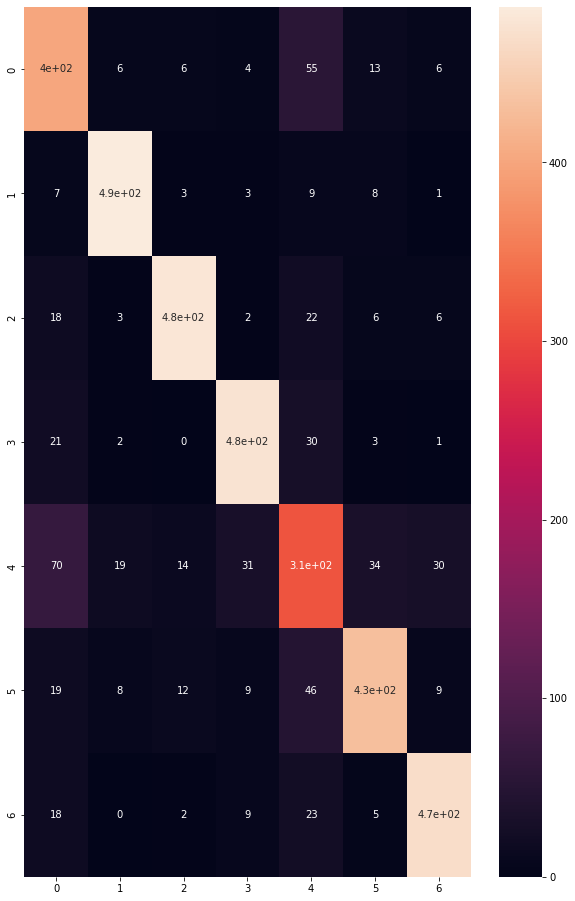

In [43]:
cm = confusion_matrix(y_test,predictions_SVM)
plt.figure(figsize=(10,16))
sns.heatmap(cm, annot=True)

In [44]:
print(classification_report(y_test,predictions_SVM))

              precision    recall  f1-score   support

           0       0.72      0.82      0.77       490
           1       0.93      0.94      0.93       518
           2       0.93      0.89      0.91       538
           3       0.89      0.89      0.89       533
           4       0.63      0.61      0.62       511
           5       0.86      0.81      0.83       533
           6       0.90      0.89      0.90       526

    accuracy                           0.84      3649
   macro avg       0.84      0.84      0.84      3649
weighted avg       0.84      0.84      0.84      3649



Berdasarkan evaluasi model diatas, maka model yang terbaik adalah SVM. Untuk tahapan selanjutnya yaitu deploy, kita akan menggunakan model SVM

# Membangun Pipeline

Pipeline merupakan urutan langkah-langkah yang memudahkan untuk deployment dikarenakan langkah2 yang telah dilakukan saat tahap produksi (tahap sekarang ini) dapat dijadikan dalam beberapa baris code saja

In [45]:
X = df['Lemmatized']
y = encoder.fit_transform(df['Category'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4, random_state = 25)

pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(ngram_range = (2,3),lowercase=True)),
                            ('model', svm.SVC(C=1.0, kernel="linear", degree=3, gamma = "scale"))])

pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 3))),
                ('model', SVC(kernel='linear'))])

In [46]:
print(X_test[:3])
pipeline.predict(X_test[:3])

2935    partai demokrat kubu moeldoko mengajukan bandi...
498     kevin sanjaya sukamuljo marcus fernaldi gideon...
3046    dana moneter internasional international monet...
Name: Lemmatized, dtype: object


array([4, 5, 4])

# Menyimpan

In [47]:
dump(pipeline,filename = 'pipeline.joblib')

['pipeline.joblib']